
# Assignment - 3  
## Multi-Agent Drone Delivery System using Hybrid Agent Architecture (Enhanced Version)

This notebook now includes:
- Entropy-based weather decision model
- Decision-tree inspired disturbance handling
- Drone path visualization using matplotlib
- Improved dynamic rescheduling



## Hybrid Agent Architecture

Each Drone Agent contains:

### 1. Reactive Layer
- Obstacle avoidance
- Collision avoidance
- Immediate wind correction

### 2. Deliberative Layer
- A* path planning
- Energy-aware routing
- Delivery optimization

### 3. Learning / Decision Layer
- Entropy-based weather disturbance prediction
- Battery-aware task reassignment

### Coordinator Agent
- Assigns tasks
- Monitors battery
- Reschedules dynamically
- Ensures coordination among 3 drones


In [1]:

import heapq
import random
import math
import matplotlib.pyplot as plt

GRID_SIZE = 10

def create_environment():
    grid = [[0 for _ in range(GRID_SIZE)] for _ in range(GRID_SIZE)]
    for _ in range(15):
        x = random.randint(0, GRID_SIZE-1)
        y = random.randint(0, GRID_SIZE-1)
        grid[x][y] = 1
    return grid

environment = create_environment()
environment


[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 1, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 1, 0, 0, 0, 0, 1],
 [0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 1, 0, 0, 0, 0, 0, 0, 1]]

In [2]:

# Entropy Calculation for Weather Disturbance

def entropy(probabilities):
    return -sum(p * math.log2(p) for p in probabilities if p > 0)

# Simulated weather data: Calm (0) or Windy (1)
weather_data = [random.choice([0,1]) for _ in range(20)]
calm_prob = weather_data.count(0) / len(weather_data)
wind_prob = weather_data.count(1) / len(weather_data)

weather_entropy = entropy([calm_prob, wind_prob])

print("Weather Data:", weather_data)
print("Entropy of Weather:", weather_entropy)

def predict_weather():
    # If entropy high -> unpredictable -> assume disturbance
    if weather_entropy > 0.8:
        return 1
    return random.choice([0,1])


Weather Data: [0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1]
Entropy of Weather: 0.9709505944546686


In [3]:

def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def astar(grid, start, goal):
    rows, cols = len(grid), len(grid[0])
    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}
    g_score = {start: 0}
    
    while open_set:
        _, current = heapq.heappop(open_set)
        
        if current == goal:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            return path[::-1]
        
        neighbors = [(0,1),(1,0),(0,-1),(-1,0)]
        for dx, dy in neighbors:
            neighbor = (current[0]+dx, current[1]+dy)
            
            if 0 <= neighbor[0] < rows and 0 <= neighbor[1] < cols:
                if grid[neighbor[0]][neighbor[1]] == 1:
                    continue
                
                tentative_g = g_score[current] + 1
                if neighbor not in g_score or tentative_g < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g
                    f_score = tentative_g + heuristic(neighbor, goal)
                    heapq.heappush(open_set, (f_score, neighbor))
    
    return None


In [4]:

class Drone:
    def __init__(self, drone_id, position):
        self.id = drone_id
        self.position = position
        self.battery = 100
        self.task = None
        self.path = []
        
    def assign_task(self, delivery_point):
        self.task = delivery_point
        
    def plan_route(self, grid):
        if self.task:
            self.path = astar(grid, self.position, self.task)
        return self.path
    
    def move_along_path(self):
        if self.path:
            for step in self.path[1:]:
                disturbance = predict_weather()
                if disturbance:
                    self.battery -= 2
                self.position = step
                self.battery -= 1


In [5]:

class Coordinator:
    def __init__(self, drones):
        self.drones = drones
        
    def assign_deliveries(self, deliveries):
        for drone, delivery in zip(self.drones, deliveries):
            drone.assign_task(delivery)
    
    def reschedule(self):
        for drone in self.drones:
            if drone.battery < 20:
                print(f"Drone {drone.id} low battery. Task rescheduled.")
                drone.task = None


In [6]:

# Initialize drones
drones = [
    Drone(1, (0,0)),
    Drone(2, (9,0)),
    Drone(3, (0,9))
]

coordinator = Coordinator(drones)
deliveries = [(8,8), (5,5), (9,9)]
coordinator.assign_deliveries(deliveries)

for drone in drones:
    drone.plan_route(environment)
    drone.move_along_path()

coordinator.reschedule()

for drone in drones:
    print(f"Drone {drone.id} Final Position: {drone.position}, Battery: {drone.battery}")


Drone 1 Final Position: (8, 8), Battery: 52
Drone 2 Final Position: (5, 5), Battery: 73
Drone 3 Final Position: (0, 9), Battery: 100


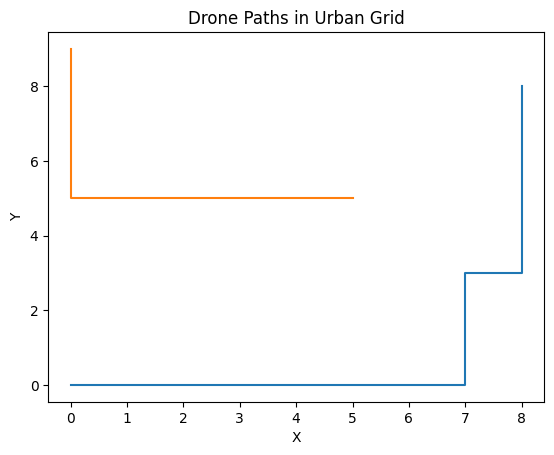

In [7]:

# Visualization (Single Plot Only)

plt.figure()
for drone in drones:
    if drone.path:
        x = [p[1] for p in drone.path]
        y = [p[0] for p in drone.path]
        plt.plot(x, y)
        
plt.title("Drone Paths in Urban Grid")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()
